# PySpice

 Video tutorial accompanying this notebook can be  [here](https://www.youtube.com/watch?v=3QyAJCCmsRs).

Steps to install within a conda environment:

- `conda create -n pytorch`
- `conda activate pytorch`
- `conda install -c conda-forge pytorch`
- `conda install -c conda-forge ngspice ngspice-lib`
- `conda install ipykernel`
- `ipython kernel install --user --name=pytorch`

## Import Relevant Modules

In [1]:
# Logging information about the simulation
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

In [2]:
from PySpice.Spice.Netlist import Circuit # for creating circuits
from PySpice.Unit import *                # for adding units

Import numpy and matplotlib for data analysis and plotting

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Use LaTex fonts/style in plots

In [4]:
matplotlib.rcParams.update({'font.size': 14,
                            'text.usetex': True, # use TeX backend
                            'mathtext.fontset': 'cm', # computer modern
                            'mathtext.rm': 'serif'})

## Template

The process of creating and simulating a circuit in PySpice can be summarized as follows:

- Create a circuit instance
- Add components to the circuit
- Set up the simulator
- Simulate the circuit
- Read the result

### Example 1: A simple resistive divider circuit

![circuit1](./images/cir1.svg)

Instantiate a circuit instance

In [5]:
circuit = Circuit('Resistive Divider')

Add components to the circuit as shown in the schematic

In [6]:
circuit.V(1, 'n_in', circuit.gnd, 10@u_V)
circuit.R(1, 'n_in', 'n_out', 2@u_kOhm)
circuit.R(2, 'n_out', circuit.gnd, 3@u_kOhm)

Resistor R2

Print the netlist so far

In [7]:
print(circuit)

.title Resistive Divider
V1 n_in 0 10V
R1 n_in n_out 2kOhm
R2 n_out 0 3kOhm



Create a simulator object (with some parameters)

In [8]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
print(simulator)

2022-04-21 04:13:46,089 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._init_ngspice - WARNING - Unsupported Ngspice version 36
.title Resistive Divider
V1 n_in 0 10V
R1 n_in n_out 2kOhm
R2 n_out 0 3kOhm
.options TEMP = 25C
.options TNOM = 25C
.ic 
.end



Run operating point analysis

In [9]:
analysis = simulator.operating_point()

Print out node voltages

In [10]:
for node in analysis.nodes.values():
    print(f"{str(node)}: {float(node)}V")

n_out: 6.0V
n_in: 10.0V


Print out the node voltage of a specific node

In [11]:
print(float(analysis.nodes['n_out']))

6.0


Print out the current through the independent voltage sources

In [12]:
for branch in analysis.branches.values():
    print(f"{str(branch)}: {float(branch)}A")

v1: -0.002A


### Example 2: A second-order RC Circuit

![circuit5](./images/cir5.svg)

In [13]:
from PySpice.Spice.Netlist import SubCircuit # for creating subcircuits

Let's create an RC subcircuit that we can reuse

In [14]:
class RC(SubCircuit):
    __nodes__ = ('n1', 'n2')
    def __init__(self, name, R1=1@u_kOhm, C1=10@u_uF):
        SubCircuit.__init__(self, name, *self.__nodes__)
        self.R(1, 'n1', 'n2', R1)
        self.C(1, 'n2', circuit.gnd, C1)

In [15]:
# Instantiate a new circuit instance
circuit = Circuit('Second Order RC Circuit')

Add the subcircuit to the netlist

In [16]:
circuit.subcircuit(RC(name='RC_BLOCK', C1=1@u_uF))
print(circuit)

.title Second Order RC Circuit
.subckt RC_BLOCK n1 n2
R1 n1 n2 1kOhm
C1 n2 0 1uF
.ends RC_BLOCK




Use the subcircuit like any other circuit component

In [17]:
circuit.SinusoidalVoltageSource(1, 'n_in', circuit.gnd, amplitude=1@u_V)
circuit.X('1', 'RC_BLOCK', 'n_in', 'n_12')
circuit.X('2', 'RC_BLOCK', 'n_12', 'n_out')
print(circuit)

.title Second Order RC Circuit
.subckt RC_BLOCK n1 n2
R1 n1 n2 1kOhm
C1 n2 0 1uF
.ends RC_BLOCK
V1 n_in 0 DC 0V AC 1V SIN(0V 1V 50Hz 0s 0Hz)
X1 n_in n_12 RC_BLOCK
X2 n_12 n_out RC_BLOCK



Let's do an AC simulation

In [18]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.ac(start_frequency=1@u_Hz, stop_frequency=10@u_MHz, number_of_points=10,  variation='dec')

Get the frequency and output voltage

In [19]:
frequency = analysis.frequency
v_out = np.array(analysis['n_out'])

Calculate the gain and phase from the output voltage

In [20]:
gain = 20*np.log10(np.absolute(v_out))
phase = np.angle(v_out, deg=True)

Make a Bode Plot

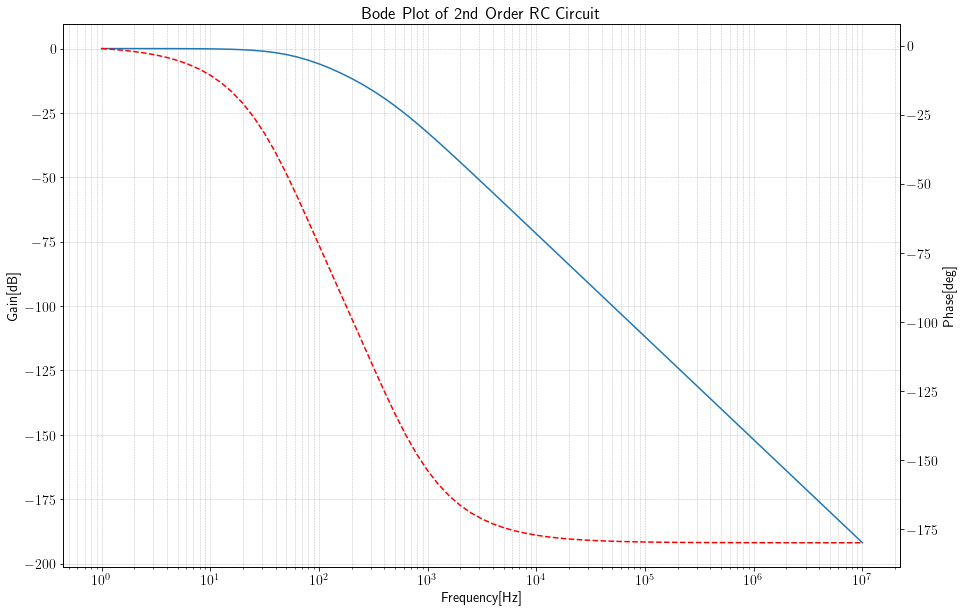

In [21]:
fig, ax1 = plt.subplots(figsize=(15,10))

# setup plot
ax1.set(xlabel="Frequency[Hz]",
        ylabel="Gain[dB]",
        title ="Bode Plot of 2nd Order RC Circuit")

ax2 = ax1.twinx()

ax2.set_ylabel("Phase[deg]")

ax1.set_xscale("log")
ax1.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5, which="both")
#####

ax1.plot(frequency, gain)
ax2.plot(frequency, phase, linestyle='dashed', color='red')

plt.show()

### Example 3: A simple diode circuit

![circuit2](./images/cir2.svg)

First, let's build the circuit without the diode

In [22]:
# Instantiate a circuit instance
circuit = Circuit('Diode circuit')

In [23]:
circuit.V(1, 'n_in', circuit.gnd, 1@u_V)
circuit.R(1, 'n_in', 'n_out', 1@u_kOhm)
print(circuit)

.title Diode circuit
V1 n_in 0 1V
R1 n_in n_out 1kOhm



We can specify a SPICE model in several ways:

1. The first way is to define the model using with PySpice
2. The second method is to import the model or subcircuit from a library
2. The third way is to use raw SPICE syntax

#### Method 1: Define the model using with PySpice

In [24]:
circuit.model('1N4148', 'D',
               IS = 4.352E-9, N = 1.906,   BV = 110,
              IBV = 0.0001,  RS = 0.6458, CJO = 7.048E-13,
               VJ = 0.869,    M = 0.03,    FC = 0.5, TT = 3.48E-9)

<class 'PySpice.Spice.Netlist.DeviceModel'> 1N4148

We can now include the diode in our circuit

In [25]:
circuit.D(1, 'n_out', circuit.gnd, model='1N4148')

Diode D1

#### Method 2: Import the subcircuit or model from a library

In [ ]:
from PySpice.Spice.Library import SpiceLibrary

In [ ]:
spice_library = SpiceLibrary("./models")
circuit.include(spice_library['1N4148'])

We can now include the diode as a subcircuit

In [ ]:
circuit.X('D', '1N4148', 'n_out', circuit.gnd)

#### Method 3: Use raw SPICE

In [ ]:
circuit.raw_spice = """
.model 1N4148 D (BV=110 CJO=7.048e-13 FC=0.5 IBV=0.0001 IS=4.352e-09 M=0.03 N=1.906 RS=0.6458 TT=3.48e-09 VJ=0.869)
"""

Print the circuit so far

In [26]:
print(circuit)

.title Diode circuit
V1 n_in 0 1V
R1 n_in n_out 1kOhm
D1 n_out 0 1N4148
.model 1N4148 D (BV=110 CJO=7.048e-13 FC=0.5 IBV=0.0001 IS=4.352e-09 M=0.03 N=1.906 RS=0.6458 TT=3.48e-09 VJ=0.869)



Let's do a DC sweep

In [27]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.dc(V1=slice(0, 1, 0.001))

Get the data points

In [28]:
current_name = str(analysis['V1'])
current_values = np.array(analysis['V1'])

Plot the current

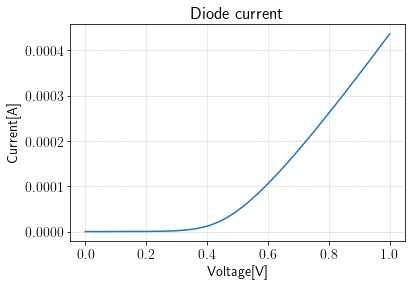

In [29]:
fig, ax = plt.subplots()

# setup plot
ax.set(xlabel="Voltage[V]",
       ylabel="Current[A]",
       title ="Diode current")

ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

x = np.linspace(0, 1, len(current_values))
ax.plot(x, -current_values)

plt.show()

### Example 4: Transient Analysis

![circuit4](./images/cir4.png)

In [30]:
circuit = Circuit('Charging Capacitor')

circuit.V(1, 'n_in', 0, 5)
circuit.PulseVoltageSource(2, 'n_swp', 0, initial_value=-1, pulsed_value=1, pulse_width=1, period=2,
                           delay_time=2@u_ns, rise_time=0, fall_time=0, phase=None, dc_offset=0)
circuit.VoltageControlledSwitch(1, 'n_r1', 'n_in', 'n_swp', 0, model='switch1')
circuit.model('switch1', 'SW',  Ron=.002@u_Ohm,  Roff=1@u_MOhm)
circuit.R(1, 'n_r1', 'n_c1', 1@u_kOhm)
circuit.C(1, 'n_c1', 0, 1@u_pF, ic=2@u_V)
print(circuit)

.title Charging Capacitor
V1 n_in 0 5
V2 n_swp 0 DC 0V PULSE(-1V 1V 2ns 0s 0s 1s 2s)
S1 n_r1 n_in n_swp 0 switch1
R1 n_r1 n_c1 1kOhm
C1 n_c1 0 1pF ic=2V
.model switch1 SW (Roff=1MegOhm Ron=0.002Ohm)



In [31]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=0.01E-9, end_time=6E-9, use_initial_condition=True)

In [32]:
time_values = analysis.time
v_pulse = analysis.nodes['n_swp']
v_c1 = analysis.nodes['n_c1']

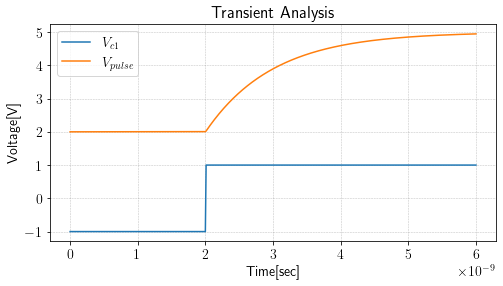

In [33]:
fig, ax = plt.subplots(figsize=(8,4))

# setup plot
ax.set(xlabel="Time[sec]",
       ylabel="Voltage[V]",
       title ="Transient Analysis")

ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

ax.plot(time_values, v_pulse, label='$V_{c1}$')
ax.plot(time_values, v_c1, label='$V_{pulse}$')
ax.legend()

plt.show()

### Example 5: MOS Curves

![circuit3](./images/cir3.svg)

In [34]:
def mos_circuit(params=None):
    
    d = {'vg':1, 'vd':2, 'length':1E-6, 'width':10E-6}
    if params:
        for k, v in params.items():
            d[k] = v
        
    circuit = Circuit('MOS circuit')
    circuit.model('NMOS-SH', 'nmos', Kp=190E-6, Vto=0.57, Lambda=0.16, Gamma=0.50, Phi=0.7)
    circuit.V('G', 'VG', 0, d['vg'])
    circuit.V('D', 'VD', 0, d['vd'])
    circuit.M(1, 'VD', 'VG', 0, 0, model='NMOS-SH', l=d['length'], w=d['width'])
    return circuit

In [35]:
def sweep_source(first_source_name, first_source_range, second_source_name, second_source_range):
    y = []
    
    for s in second_source_range:
        circuit = mos_circuit({f'{second_source_name}':s})
        simulator = circuit.simulator(temperature=25, nominal_temperature=25)
        if first_source_name == 'vg':
            analysis = simulator.dc(VG=first_source_range)
        else:
            analysis = simulator.dc(VD=first_source_range)
        y.append(- np.array(analysis.branches['vd']))
        
    x = np.array(analysis.nodes[first_source_name])
    return x, y

In [36]:
def plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range, func=lambda x: x):
    fig, ax = plt.subplots(figsize=(8,4))

    # setup plot
    ax.set(xlabel=x_label,
           ylabel=y_label,
           title =title)

    ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

    for i, s in enumerate(second_source_range):
        ax.plot(x, func(y[i]), label=f'{second_source_name} = {str(s)}V')

    ax.legend()
    plt.show()

Plot $I_D$ vs. $V_{DS}$ as $V_{GS}$ is varied.

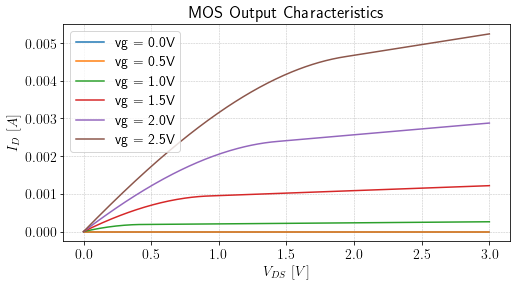

In [37]:
first_source_name = 'vd'
first_source_range = slice(0, 3, .01)
second_source_name = 'vg'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label ="$V_{DS}\ [V]$"
y_label ="$I_{D}\ [A]$"
title ="MOS Output Characteristics"

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range)

Plot $I_D$ vs. $V_{GS}$ as $V_{DS}$ is varied.

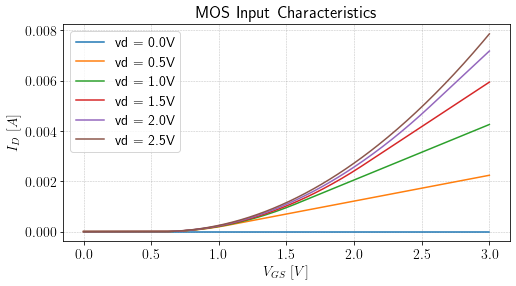

In [38]:
first_source_name = 'vg'
first_source_range = slice(0, 3, .01)
second_source_name = 'vd'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label ="$V_{GS}\ [V]$"
y_label ="$I_{D}\ [A]$"
title ="MOS Input Characteristics"

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range)

Plot $g_m$ vs. $V_{GS}$ as $V_{DS}$ is varied.

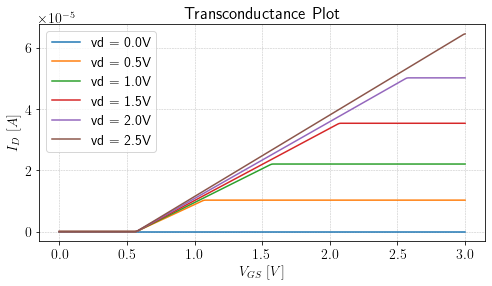

In [39]:
first_source_name = 'vg'
first_source_range = slice(0, 3, .01)
second_source_name = 'vd'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label ="$V_{GS}\ [V]$"
y_label ="$I_{D}\ [A]$"
title ="Transconductance Plot"

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range, np.gradient)

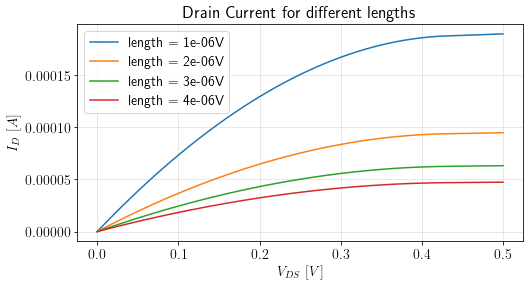

In [40]:
first_source_name = 'vd'
first_source_range = slice(0, 0.5, .01)
second_source_name = 'length'
second_source_range = np.arange(1, 5, 1) * 1E-6

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label ="$V_{DS}\ [V]$"
y_label ="$I_{D}\ [A]$"
title ="Drain Current for different lengths"

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range)

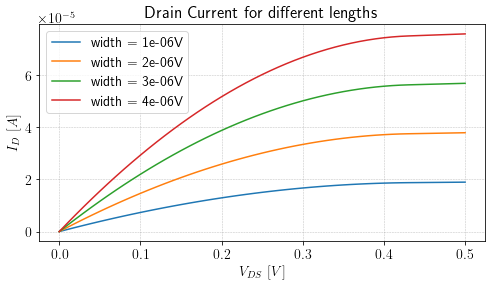

In [41]:
first_source_name = 'vd'
first_source_range = slice(0, 0.5, .01)
second_source_name = 'width'
second_source_range = np.arange(1, 5, 1) * 1E-6

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label ="$V_{DS}\ [V]$"
y_label ="$I_{D}\ [A]$"
title ="Drain Current for different lengths"

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range)

## Example 6: Frequency Spectrum

![circuit6](./images/cir6.svg)

In [42]:
from scipy.fftpack import fft, fftfreq

In [43]:
circuit = Circuit("BJT Amplifier")

source_frequency = 1e3

circuit.SinusoidalVoltageSource('ref', 'n_in', 0, amplitude=3, frequency=source_frequency)
circuit.V('cc', 'n_1', 0, 5)
circuit.Q('ref', 'n_out', 'n_2', 0, model='2N2222')
circuit.R('ref', 'n_1', 'n_out', 10e3)
circuit.R(2, 'n_1', 'n_2', 50e3)
circuit.R(3, 'n_2', 0, 10e3)
circuit.R(4, 'n_2', 'n_in', 100e3)

circuit.raw_spice = """
.model 2N2222 NPN(IS=1E-14 VAF=100
+   BF=200 IKF=0.3 XTB=1.5 BR=3
+   CJC=8E-12 CJE=25E-12 TR=100E-9 TF=400E-12
+   ITF=1 VTF=2 XTF=3 RB=10 RC=.3 RE=.2)

"""

print(circuit)

.title BJT Amplifier

.model 2N2222 NPN(IS=1E-14 VAF=100
+   BF=200 IKF=0.3 XTB=1.5 BR=3
+   CJC=8E-12 CJE=25E-12 TR=100E-9 TF=400E-12
+   ITF=1 VTF=2 XTF=3 RB=10 RC=.3 RE=.2)

Vref n_in 0 DC 0V AC 1V SIN(0V 3V 1000.0Hz 0s 0Hz)
Vcc n_1 0 5
Qref n_out n_2 0 2N2222
Rref n_1 n_out 10000.0
R2 n_1 n_2 50000.0
R3 n_2 0 10000.0
R4 n_2 n_in 100000.0



In [44]:
reference_signal_period = 1 / source_frequency
sample_points_per_period = 100
number_of_periods_to_capture = 50

sampling_time = reference_signal_period / sample_points_per_period
end_time = number_of_periods_to_capture * reference_signal_period

In [45]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=sampling_time, end_time=end_time)

In [46]:
time_values = np.array(analysis.time)
v_in = np.array(analysis['n_in'])
v_out = np.array(analysis['n_out'])

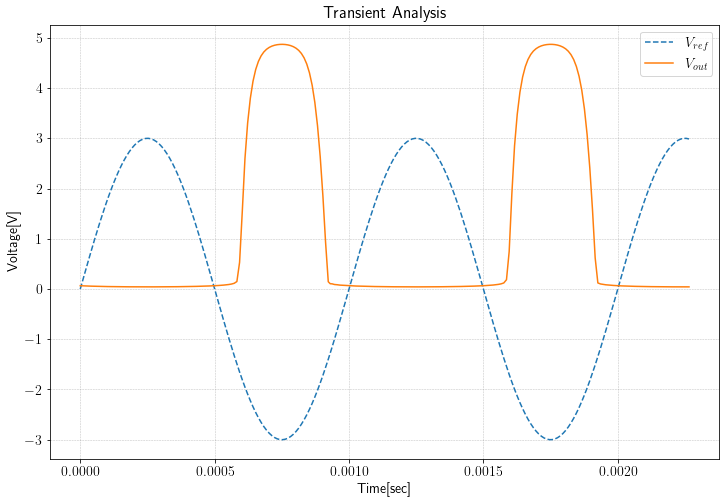

In [47]:
fig, ax = plt.subplots(figsize=(12,8))

# setup plot
ax.set(xlabel="Time[sec]",
       ylabel="Voltage[V]",
       title ="Transient Analysis")

ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

# just plot 2 periods to avoid congestion in the plot
stop = sample_points_per_period * 2 + len(time_values) - sample_points_per_period * number_of_periods_to_capture

ax.plot(time_values[:stop], v_in[:stop], linestyle = 'dashed', label='$V_{ref}$')
ax.plot(time_values[:stop], v_out[:stop], label='$V_{out}$')
ax.legend()

plt.show()

In [48]:
def plot_frequency_spectrum(sampling_time, time_values, signal):
    
    # total number of sample points
    N = len(time_values)

    # sampling time
    T = sampling_time

    # translate time-domain signal to the frequency domain via the fft
    xf = fftfreq(N, T)[:N//2]
    yf = fft(signal - np.mean(signal)) # remove the dc
    spectrum = 2.0/N * np.abs(yf[0:N//2])
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Frequency Spectrum')
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Amplitude')
    ax.grid()
    ax.plot(xf, spectrum)
    plt.show()

The input is a pure sine wave. So, we should see a single peak in the frequency domain.

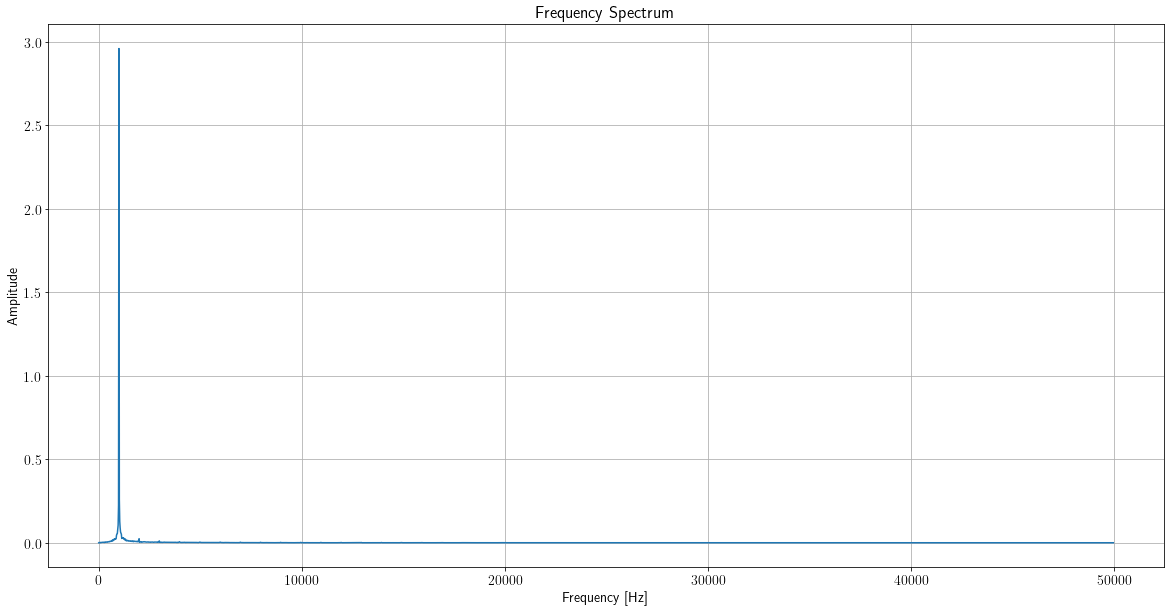

In [49]:
plot_frequency_spectrum(sampling_time, time_values, v_in)

The output waveform is distorted. So, we should should see high frequency harmonics in the frequency plot.

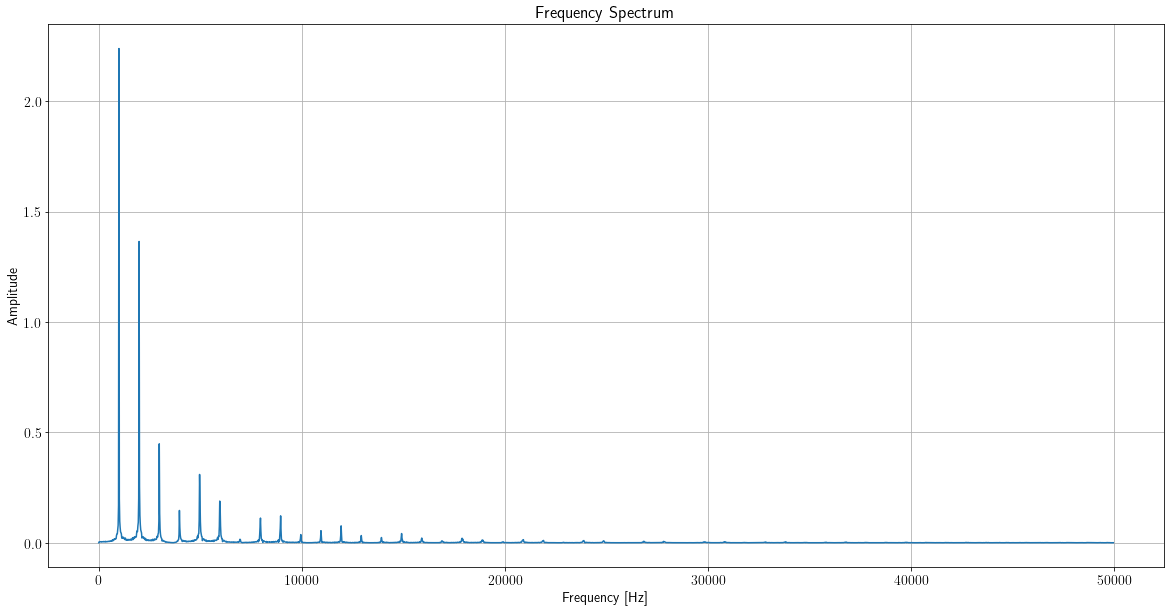

In [50]:
plot_frequency_spectrum(sampling_time, time_values, v_out)